# Import

In [ ]:
pip install scikeras

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Layer, GRU, Dense, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from scikeras.wrappers import KerasRegressor

# Preprocessing

In [ ]:
data = pd.read_csv('/content/Keseluruhan NonMigas.csv')
data['date'] = pd.to_datetime(data['date'], format='%Y %B')
data.set_index('date', inplace=True)
data

,NonMigas
date,
1993-01-01,2137.6
1993-02-01,2125.0
1993-03-01,2116.3
1993-04-01,2213.5
1993-05-01,2229.7
...,...
2024-02-01,18056.0
2024-03-01,21252.4
2024-04-01,18264.9


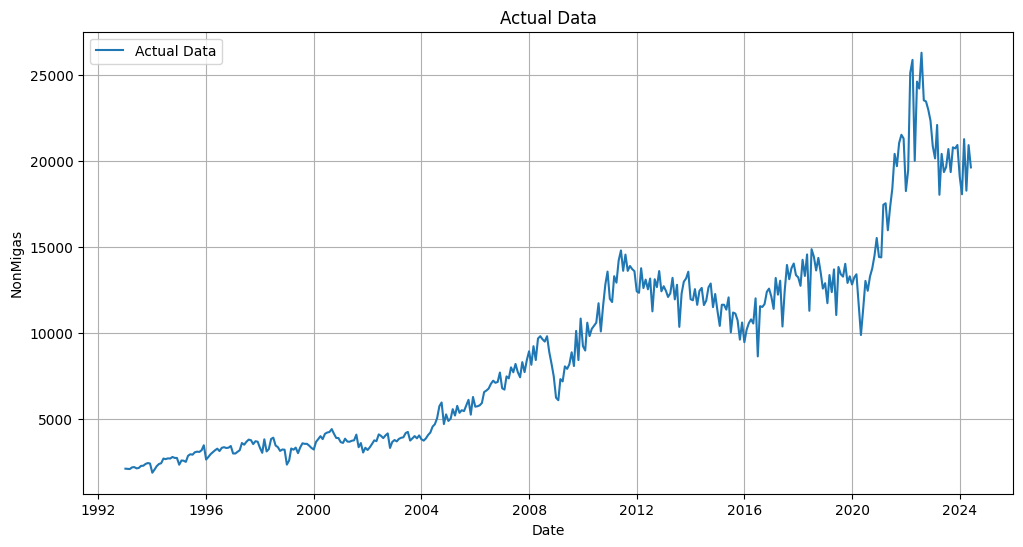

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['NonMigas'], label='Actual Data')
plt.xlabel('Date')
plt.ylabel('NonMigas')
plt.legend()
plt.title('Actual Data')
plt.grid(True)
plt.show()

In [ ]:
data.describe()

,NonMigas
count,378.000000
mean,9052.900529
std,5712.008053
min,1903.200000
25%,3732.275000
50%,8269.600000
75%,12864.975000
max,26265.800000


In [ ]:
# Extract 'NonMigas' and normalize
data_unscaled = data['NonMigas'].values.reshape(-1, 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_unscaled)
data_scaled

array([[0.0096213 ],
       [0.00910412],
       [0.00874701],
       [0.01273674],
       [0.01340169],
       [0.01034783],
       [0.011296  ],
       [0.01627495],
       [0.01664847],
       [0.02085574],
       [0.0230271 ],
       [0.02192295],
       [0.        ],
       [0.00779063],
       [0.01548685],
       [0.02083521],
       [0.02257969],
       [0.03374024],
       [0.0323816 ],
       [0.03417123],
       [0.03379771],
       [0.03752063],
       [0.03526307],
       [0.03515635],
       [0.01904969],
       [0.02919229],
       [0.02863816],
       [0.02586341],
       [0.04034052],
       [0.04402239],
       [0.04295929],
       [0.04873043],
       [0.05015885],
       [0.04948158],
       [0.05350825],
       [0.06534606],
       [0.03138828],
       [0.03751242],
       [0.04408807],
       [0.04873043],
       [0.05341384],
       [0.057264  ],
       [0.05150107],
       [0.05935738],
       [0.06074885],
       [0.0588484 ],
       [0.05967754],
       [0.063

In [ ]:
data_scaled_df = {'Data_scaled': data_scaled.flatten()}
data_scaled_df = pd.DataFrame(data_scaled_df)

In [ ]:
data_scaled_df

,Data_scaled
0,0.009621
1,0.009104
2,0.008747
3,0.012737
4,0.013402
...,...
373,0.663016
374,0.794217
375,0.671591
376,0.780015


In [ ]:
data_scaled_df.to_csv('data_scaled.csv', index=False)
data_scaled_df.to_excel('data_scaled.xlsx', index=False)

# split data

In [ ]:
# Split data into training and testing sets
train_size = int(len(data_scaled) * 0.75)
train, test = data_scaled[:train_size], data_scaled[train_size:]

In [ ]:
train.shape, test.shape

((283, 1), (95, 1))

# Data Sequence

In [ ]:
def create_sequences(data, time_steps):
    sequences = []
    labels = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
        labels.append(data[i + time_steps])
    return np.array(sequences), np.array(labels)

time_steps = 3

## check data

In [ ]:
# Create sequences for training and testing sets just for check
# X_train_dummy, y_train_dummy = create_sequences(train, time_steps)
# X_test_dummy, y_test_dummy = create_sequences(test, time_steps)


In [ ]:
# X_train_reshape = X_train_dummy.reshape(-1,3)
# X_test_reshape = X_test_dummy.reshape(-1,3)
# X_train_df = pd.DataFrame(X_train_reshape, columns=['Kolom 1','Kolom 2','Kolom 3'])
# X_train_df_all = pd.concat([X_train_df, pd.DataFrame(y_train_dummy, columns=['y_train'])], axis=1)
# X_test_df = pd.DataFrame(X_test_reshape, columns=['Kolom 1','Kolom 2','Kolom 3'])
# X_test_df_all = pd.concat([X_test_df, pd.DataFrame(y_test_dummy, columns=['y_test'])], axis=1)

In [ ]:
# X_train_df_all.to_csv('X_train_df_all.csv', index=False)
# X_train_df_all.to_excel('X_train_df_all.xlsx', index=False)

# X_test_df_all.to_csv('X_test_df_all.csv', index=False)
# X_test_df_all.to_excel('X_test_df_all.xlsx', index=False)

In [ ]:
# X_train_df_all

In [ ]:
# X_test_df_all

# Stacked GRU

In [ ]:
#Create_sequence
X_train, y_train = create_sequences(train, time_steps)
X_test, y_test = create_sequences(test, time_steps)

# Check the shape of the created sequences
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((280, 3, 1), (280, 1), (92, 3, 1), (92, 1))

In [ ]:
# Define the function to build the GRU model with variable hyperparameters
def build_Stacked_GRU(units=64, dropout=0.2, learning_rate=0.001):
    model = models.Sequential()
    model.add(GRU(units, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(time_steps, 1)))
    model.add(Dropout(dropout))
    model.add(GRU(units, return_sequences=True))
    model.add(GRU(units))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap the model for GridSearch
model = KerasRegressor(
    build_fn=build_Stacked_GRU,
    epochs=50,
    batch_size=32,
    verbose=0
)

# Define the grid of hyperparameters to search
param_grid = { # Changed param_grid keys
    'model__units': [32, 64, 128],
    'model__dropout': [0.1, 0.2, 0.3],
    'model__learning_rate': [0.001, 0.01, 0.1]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3)

# Fit GridSearchCV
grid_result = grid_search.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Build the best model from the grid search results
stk_best_model = build_Stacked_GRU(units=grid_result.best_params_['model__units'],
                                      dropout=grid_result.best_params_['model__dropout'],
                                      learning_rate=grid_result.best_params_['model__learning_rate'])



/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in 

Best: -0.019305 using {'model__dropout': 0.2, 'model__learning_rate': 0.001, 'model__units': 64}


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_11 (GRU)                         │ (None, 3, 64)               │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_12 (GRU)                         │ (None, 3, 64)               │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_13 (GRU)                         │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,849 (245.50 KB)

 Trainable params: 62,849 (245.50 KB)

 Non-trainable params: 0 (0.00 B)

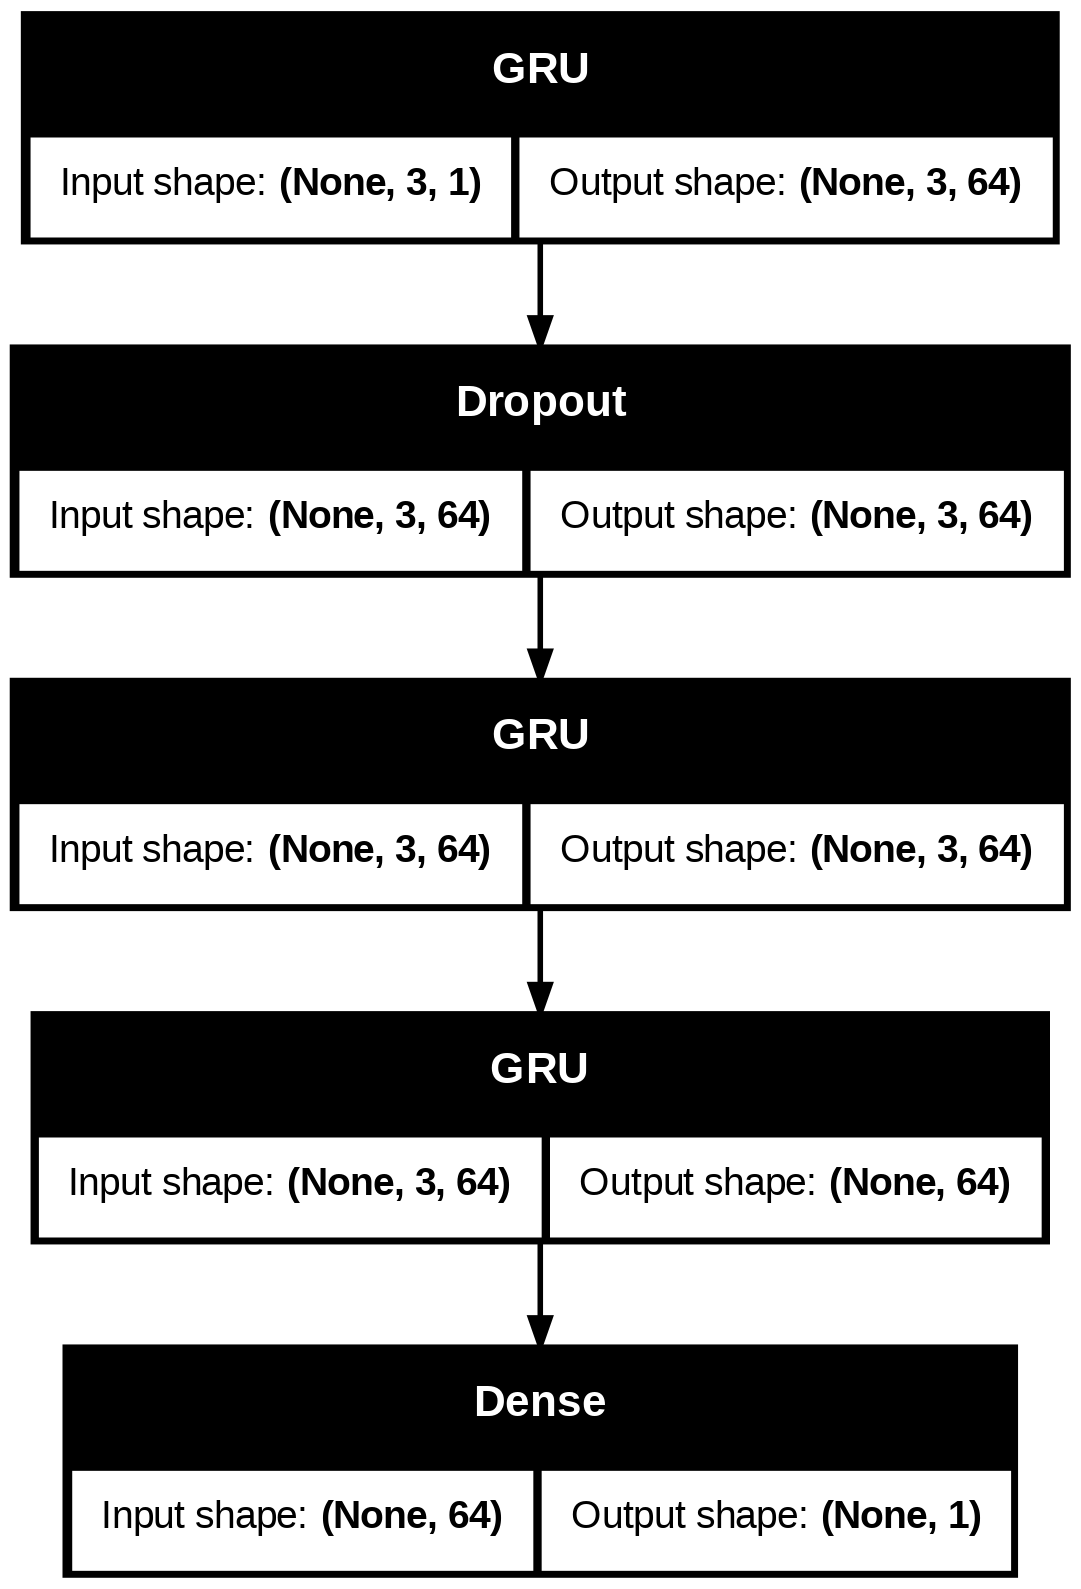

In [ ]:
# Summarize the model
stk_best_model.summary()

plot_model(stk_best_model,to_file='stk_modelgru.png', show_shapes=True)

# stk_best_model.save('stk_modelgru.h5')

In [ ]:
# Train the best model
history = stk_best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 0.0544 - val_loss: 0.0380
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0304 - val_loss: 0.0652
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0207 - val_loss: 0.0212
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0164 - val_loss: 0.0188
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0140 - val_loss: 0.0169
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0119 - val_loss: 0.0145
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0103 - val_loss: 0.0134
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0090 - val_loss: 0.0118
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0078 - val_loss: 0.0107
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0071 - val_loss: 0.0100
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0060 - val_loss: 0.0097
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0052 - val_loss: 0.0087
E

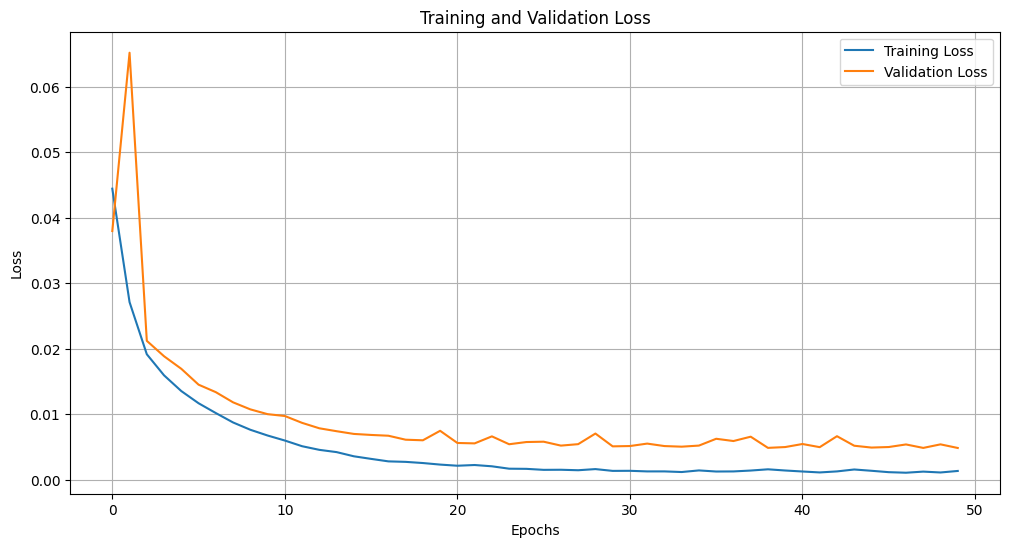

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [ ]:


# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

# Make predictions
train_predictions = stk_best_model.predict(X_train)
test_predictions = stk_best_model.predict(X_test)

In [ ]:
stk_history_df = history.history
stk_history_df = pd.DataFrame(stk_history_df)
stk_history_df.to_csv('stk_history_df.csv', index=False)
stk_history_df.to_excel('stk_history_df.xlsx', index=False)

In [ ]:
stk_history_df

,loss,val_loss
0,0.044421,0.037951
1,0.027100,0.065177
2,0.019140,0.021191
3,0.015920,0.018835
4,0.013519,0.016918
5,0.011661,0.014498
6,0.010162,0.013353
7,0.008727,0.011800
8,0.007613,0.010727
9,0.006735,0.009995


MAE: 1237.3667395550272
RMSE: 1646.3960910913133
MAPE: 7.60166150441815%
R2: 0.8433421154760763


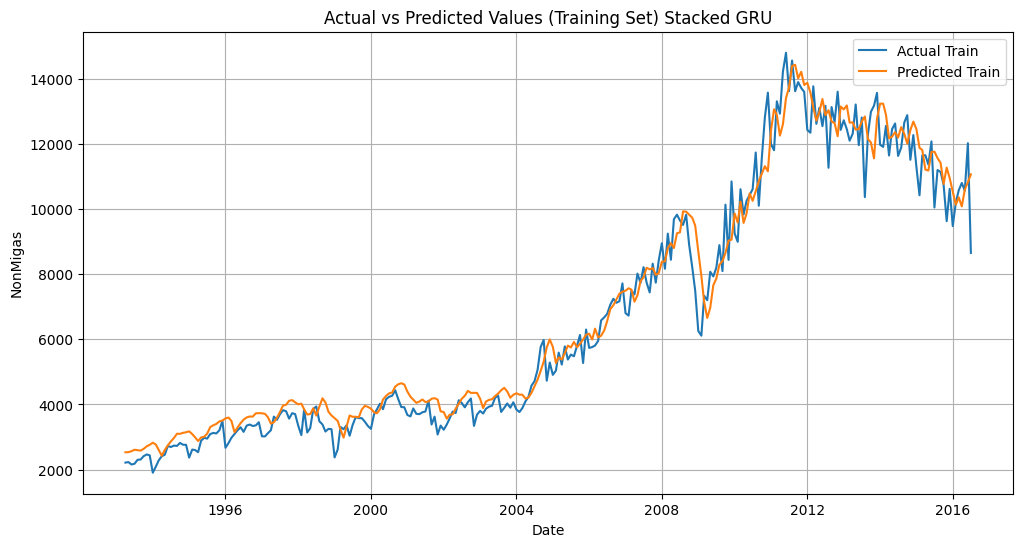

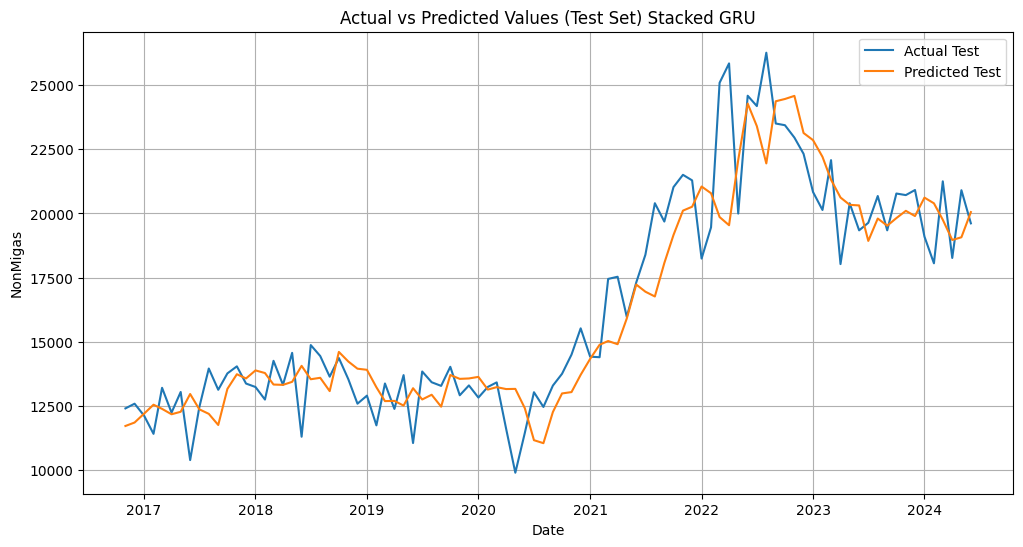

In [ ]:

# Inverse transform the training predictions and actual values
stk_train_predictions_inv = scaler.inverse_transform(train_predictions)
stk_y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))


# Inverse transform the test predictions and actual values
stk_test_predictions_inv = scaler.inverse_transform(test_predictions)
stk_y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


# Evaluate the model
# Compute MAE
stk_mae = mean_absolute_error(stk_y_test_inv, stk_test_predictions_inv)

# Compute RMSE
stk_rmse = np.sqrt(mean_squared_error(stk_y_test_inv, stk_test_predictions_inv))

# Compute MAPE
stk_mape = mean_absolute_percentage_error(stk_y_test_inv, stk_test_predictions_inv) * 100

# Compute R^2
stk_r2 = r2_score(stk_y_test_inv, stk_test_predictions_inv)

# Print hasil evaluasi
print(f'MAE: {stk_mae}')
print(f'RMSE: {stk_rmse}')
print(f'MAPE: {stk_mape}%')
print(f'R2: {stk_r2}')

# Plot the actual vs predicted values for the training set
plt.figure(figsize=(12, 6))
plt.plot(data.index[time_steps:train_size], stk_y_train_inv, label='Actual Train')
plt.plot(data.index[time_steps:train_size], stk_train_predictions_inv, label='Predicted Train')
plt.xlabel('Date')
plt.ylabel('NonMigas')
plt.legend()
plt.title('Actual vs Predicted Values (Training Set) Stacked GRU')
plt.grid(True)
plt.show()

# Plot the actual vs predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size + time_steps:], stk_y_test_inv, label='Actual Test')
plt.plot(data.index[train_size + time_steps:], stk_test_predictions_inv, label='Predicted Test')
plt.xlabel('Date')
plt.ylabel('NonMigas')
plt.legend()
plt.title('Actual vs Predicted Values (Test Set) Stacked GRU')
plt.grid(True)
plt.show()


In [ ]:
# Extract the last sequence from the test data
last_sequence = data_scaled[-time_steps:]

# Reshape it to fit the model's expected input shape
last_sequence = last_sequence.reshape((1, time_steps, 1))

# Predict the next month
next_month_prediction_scaled = stk_best_model.predict(last_sequence)

# Inverse transform the predicted value to get the actual value
next_month_prediction = scaler.inverse_transform(next_month_prediction_scaled)

# Print the predicted value for the next month
print(f'Predicted NonMigas value for the next month: {next_month_prediction[0][0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Predicted NonMigas value for the next month: 19252.0546875


In [ ]:
stk_train_predictions_inv_df = pd.DataFrame(stk_train_predictions_inv, columns=['Prediksi'])
stk_y_train_inv_df = pd.DataFrame(stk_y_train_inv, columns=['Aktual'])
stk_train = pd.concat([stk_train_predictions_inv_df, stk_y_train_inv_df], axis=1)
stk_train.to_csv('stk_train.csv', index=False)
stk_train.to_excel('stk_train.xlsx', index=False)

In [ ]:
stk_test_predictions_inv_df = pd.DataFrame(stk_test_predictions_inv,columns=['prediksi'])
stk_y_test_inv_df = pd.DataFrame(stk_y_test_inv, columns=['Aktual'])
stk_test = pd.concat([stk_test_predictions_inv_df, stk_y_test_inv_df], axis=1)
stk_test.to_csv('stk_test.csv', index=False)
stk_test.to_excel('stk_test.xlsx', index=False)

In [ ]:
stk_y_train_inv

array([[ 2213.5],
       [ 2229.7],
       [ 2155.3],
       [ 2178.4],
       [ 2299.7],
       [ 2308.8],
       [ 2411.3],
       [ 2464.2],
       [ 2437.3],
       [ 1903.2],
       [ 2093. ],
       [ 2280.5],
       [ 2410.8],
       [ 2453.3],
       [ 2725.2],
       [ 2692.1],
       [ 2735.7],
       [ 2726.6],
       [ 2817.3],
       [ 2762.3],
       [ 2759.7],
       [ 2367.3],
       [ 2614.4],
       [ 2600.9],
       [ 2533.3],
       [ 2886. ],
       [ 2975.7],
       [ 2949.8],
       [ 3090.4],
       [ 3125.2],
       [ 3108.7],
       [ 3206.8],
       [ 3495.2],
       [ 2667.9],
       [ 2817.1],
       [ 2977.3],
       [ 3090.4],
       [ 3204.5],
       [ 3298.3],
       [ 3157.9],
       [ 3349.3],
       [ 3383.2],
       [ 3336.9],
       [ 3357.1],
       [ 3452.8],
       [ 3020.2],
       [ 3017.8],
       [ 3113.2],
       [ 3207.3],
       [ 3625.8],
       [ 3527.9],
       [ 3698.2],
       [ 3823.2],
       [ 3790.5],
       [ 3564.4],
       [ 3

In [ ]:
stk_train_predictions_inv

array([[ 2529.9482],
       [ 2534.6194],
       [ 2564.638 ],
       [ 2608.1228],
       [ 2594.9934],
       [ 2582.5994],
       [ 2635.506 ],
       [ 2713.964 ],
       [ 2759.8938],
       [ 2824.9204],
       [ 2766.4045],
       [ 2603.752 ],
       [ 2425.2437],
       [ 2600.8855],
       [ 2743.9805],
       [ 2862.134 ],
       [ 2968.448 ],
       [ 3100.1133],
       [ 3096.6013],
       [ 3128.4026],
       [ 3145.9224],
       [ 3172.8918],
       [ 3088.4814],
       [ 2992.9402],
       [ 2875.7466],
       [ 2985.5813],
       [ 3006.8098],
       [ 3102.082 ],
       [ 3304.8801],
       [ 3361.3765],
       [ 3399.7463],
       [ 3479.391 ],
       [ 3505.393 ],
       [ 3570.6301],
       [ 3596.9827],
       [ 3489.9092],
       [ 3147.0825],
       [ 3290.908 ],
       [ 3424.8503],
       [ 3532.6052],
       [ 3600.7537],
       [ 3628.7695],
       [ 3626.3516],
       [ 3726.924 ],
       [ 3731.5288],
       [ 3728.6265],
       [ 3708.6245],
       [ 3613

In [ ]:
stk_y_test_inv

array([[12399.9],
       [12582.2],
       [12119.1],
       [11407.3],
       [13202.2],
       [12233.5],
       [13039.5],
       [10385.1],
       [12446.1],
       [13954.4],
       [13125.2],
       [13764.4],
       [14039. ],
       [13368.1],
       [13233.6],
       [12743.6],
       [14254.5],
       [13317.4],
       [14565.2],
       [11295. ],
       [14868.2],
       [14441.4],
       [13636.1],
       [14363.8],
       [13538.8],
       [12583.3],
       [12896.8],
       [11737.8],
       [13370.4],
       [12380. ],
       [13697.6],
       [11049.2],
       [13837.9],
       [13419.1],
       [13277.1],
       [14021.5],
       [12910.8],
       [13295.5],
       [12821.1],
       [13236.9],
       [13413.9],
       [11597.7],
       [ 9891.7],
       [11439.4],
       [13029.5],
       [12455.7],
       [13288.9],
       [13748.9],
       [14496.2],
       [15520.8],
       [14416.4],
       [14394.8],
       [17446.9],
       [17532.4],
       [15967.4],
       [17

In [ ]:
stk_test_predictions_inv

array([[11713.899 ],
       [11848.674 ],
       [12193.575 ],
       [12543.293 ],
       [12380.781 ],
       [12170.775 ],
       [12267.614 ],
       [12960.232 ],
       [12363.799 ],
       [12186.754 ],
       [11753.057 ],
       [13160.526 ],
       [13731.72  ],
       [13566.975 ],
       [13880.7295],
       [13778.265 ],
       [13329.64  ],
       [13316.334 ],
       [13434.953 ],
       [14058.348 ],
       [13535.846 ],
       [13592.135 ],
       [13073.293 ],
       [14601.346 ],
       [14227.584 ],
       [13947.645 ],
       [13903.932 ],
       [13222.937 ],
       [12684.07  ],
       [12691.851 ],
       [12508.87  ],
       [13185.946 ],
       [12747.835 ],
       [12931.827 ],
       [12466.464 ],
       [13700.868 ],
       [13551.068 ],
       [13566.85  ],
       [13628.121 ],
       [13132.736 ],
       [13228.003 ],
       [13153.003 ],
       [13160.444 ],
       [12409.056 ],
       [11160.488 ],
       [11043.388 ],
       [12258.48  ],
       [12982

# Bidirectional GRU

In [ ]:
#Create_sequence
X_train, y_train = create_sequences(train, time_steps)
X_test, y_test = create_sequences(test, time_steps)

# Check the shape of the created sequences
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((280, 3, 1), (280, 1), (92, 3, 1), (92, 1))

In [ ]:
# Define the Bidirectional GRU Model
def build_bidirectional_gru(units=64, dropout=0.2, learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Bidirectional(layers.GRU(units, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(time_steps, 1)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Bidirectional(layers.GRU(units)))
    model.add(layers.Dense(1))
    adam = Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam, loss='mse')
    return model

# Wrap the model for GridSearch
model = KerasRegressor(
    build_fn=build_bidirectional_gru,
    epochs=50,
    batch_size=32,
    verbose=0
)

# Define the grid of hyperparameters to search
param_grid = { # Changed param_grid keys
    'model__units': [32, 64, 128],
    'model__dropout': [0.1, 0.2, 0.3],
    'model__learning_rate': [0.001, 0.01, 0.1]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3)

# Fit GridSearchCV
grid_result = grid_search.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Build the best model from the grid search results
bid_best_model = build_bidirectional_gru(units=grid_result.best_params_['model__units'],
                                      dropout=grid_result.best_params_['model__dropout'],
                                      learning_rate=grid_result.best_params_['model__learning_rate'])

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as

Best: -0.018726 using {'model__dropout': 0.1, 'model__learning_rate': 0.001, 'model__units': 64}


Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_164 (Bidirectional)    │ (None, 3, 128)              │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_82 (Dropout)                 │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_165 (Bidirectional)    │ (None, 128)                 │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,353 (392.00 KB)

 Trainable params: 100,353 (392.00 KB)

 Non-trainable params: 0 (0.00 B)

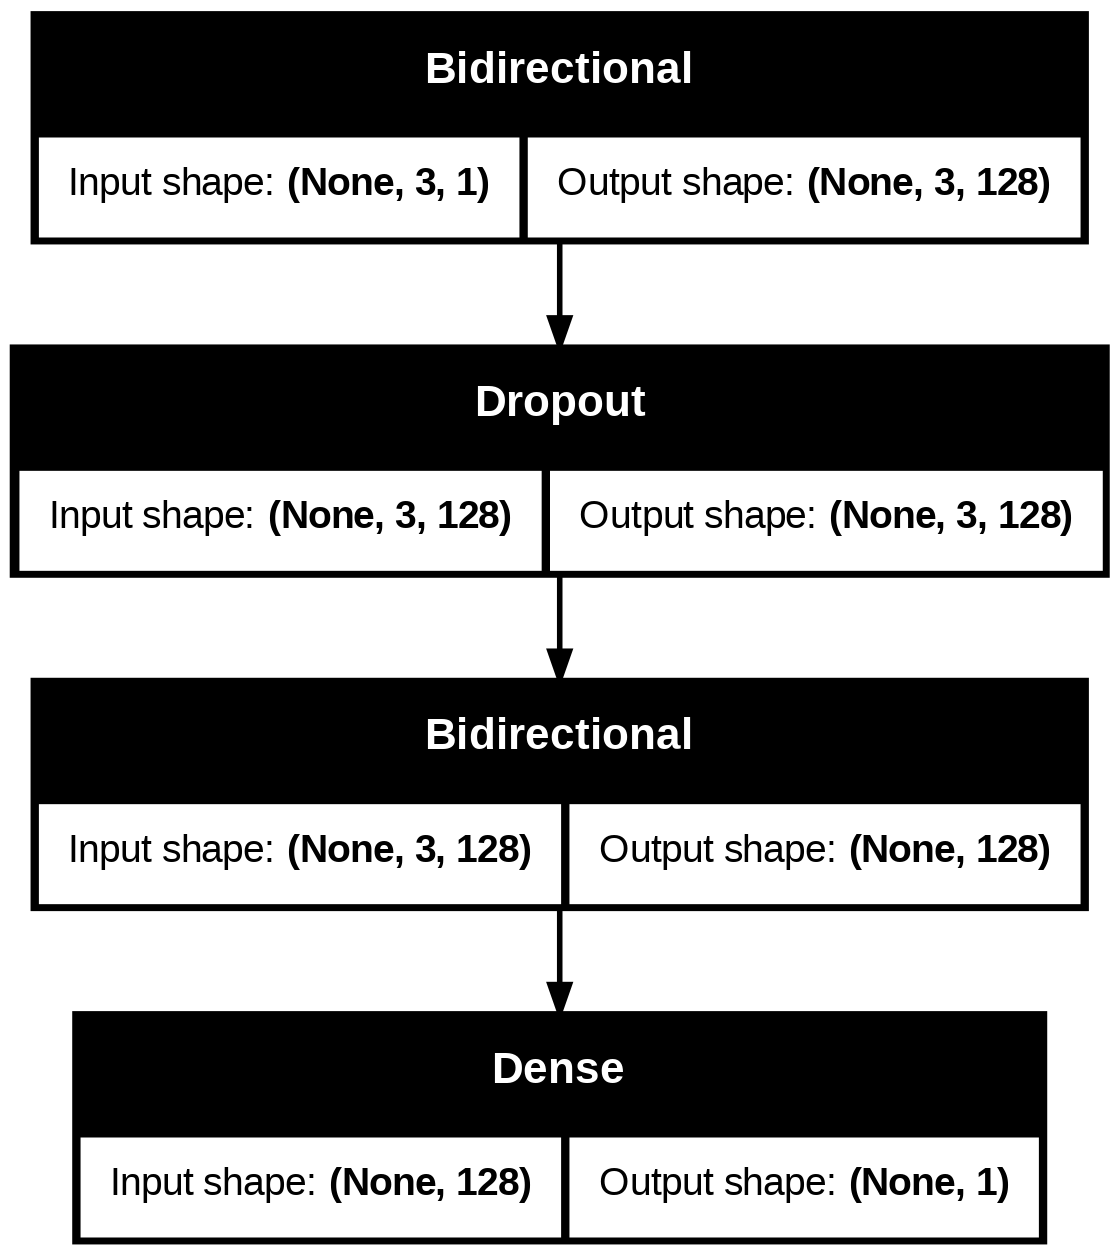

In [ ]:
# Summarize the model
bid_best_model.summary()

plot_model(bid_best_model,to_file='bid_modelgru.png', show_shapes=True)

# bid_best_model.save('bid_modelgru.h5')

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - loss: 0.0700 - val_loss: 0.0408
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0455 - val_loss: 0.0419
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0366 - val_loss: 0.0341
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0315 - val_loss: 0.0326
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0284 - val_loss: 0.0263
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0250 - val_loss: 0.0238
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0219 - val_loss: 0.0208
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0194 - val_loss: 0.0184
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0172 - val_loss: 0.0164
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0152 - val_loss: 0.0146
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0133 - val_loss: 0.0129
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0119 - val_loss: 0.0115


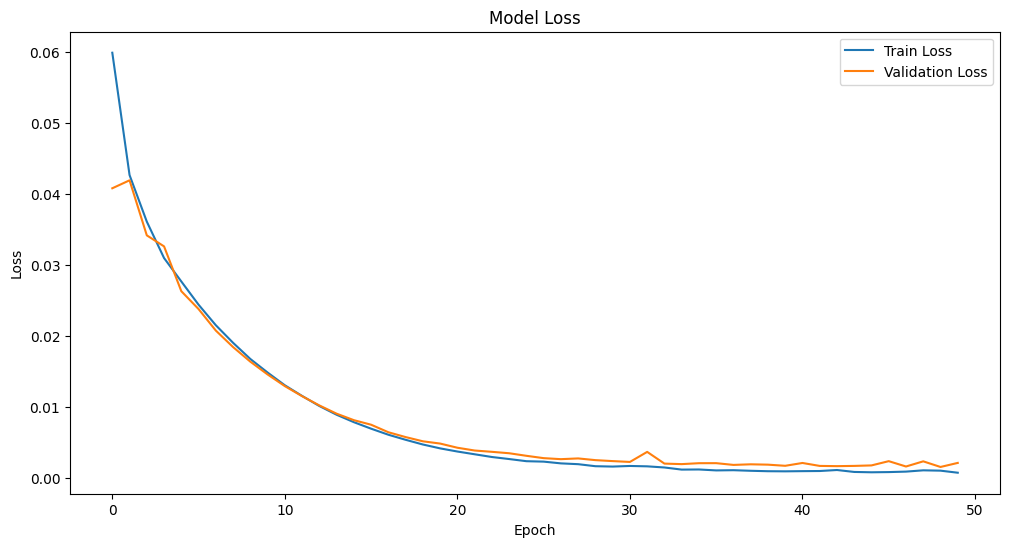

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [ ]:
# Train the model
history = bid_best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions
train_predictions = bid_best_model.predict(X_train)
test_predictions = bid_best_model.predict(X_test)



In [ ]:
bid_history_df = history.history
bid_history_df = pd.DataFrame(bid_history_df)
bid_history_df.to_csv('bid_history_df.csv', index=False)
bid_history_df.to_excel('bid_history_df.xlsx', index=False)

In [ ]:
bid_history_df

,loss,val_loss
0,0.059837,0.040773
1,0.042630,0.041892
2,0.036080,0.034150
3,0.030960,0.032599
4,0.027665,0.026298
5,0.024397,0.023784
6,0.021512,0.020759
7,0.019038,0.018439
8,0.016766,0.016386
9,0.014860,0.014588


MAE: 1197.5976435122282
RMSE: 1614.4568889328102
MAPE: 7.466893690707703%
R2: 0.8493613170406444


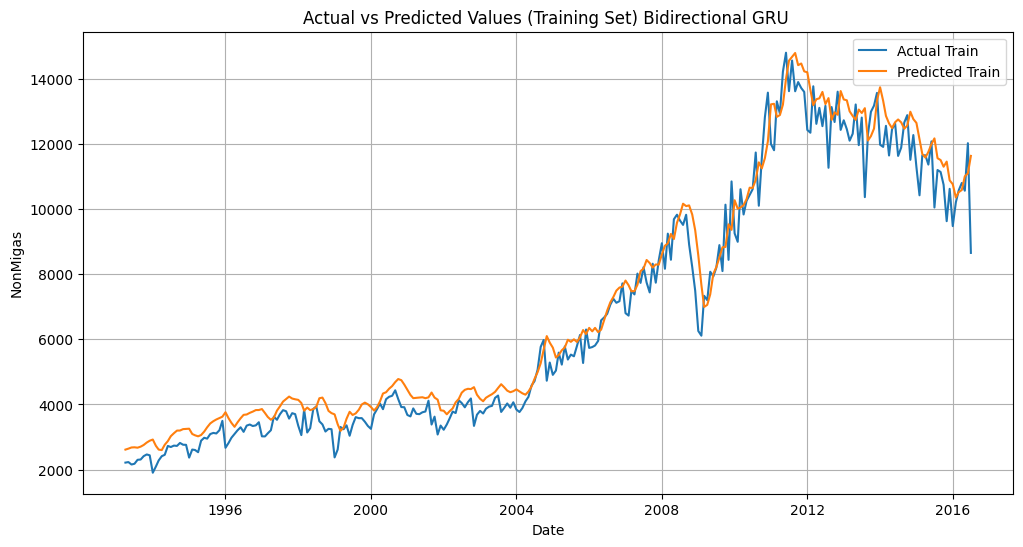

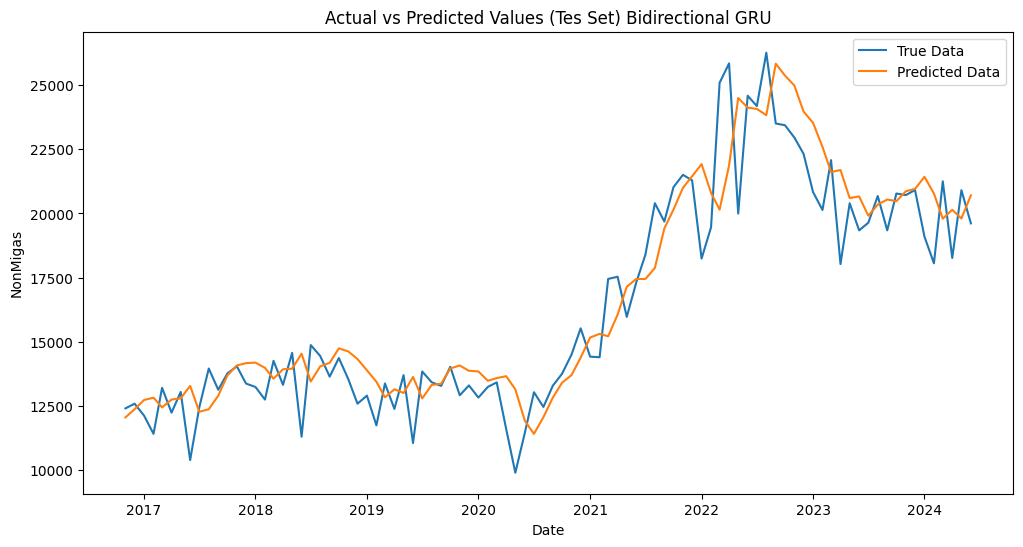

In [ ]:
# Rescale predictions back to original values
bid_test_predictions_inv = scaler.inverse_transform(test_predictions)
bid_y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Rescale predictions back to original values
bid_train_predictions_inv = scaler.inverse_transform(train_predictions)
bid_y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))

# Evaluate the model
# Compute MAE
bid_mae = mean_absolute_error(bid_y_test_inv, bid_test_predictions_inv)

# Compute RMSE
bid_rmse = np.sqrt(mean_squared_error(bid_y_test_inv, bid_test_predictions_inv))

# Compute MAPE
bid_mape = mean_absolute_percentage_error(bid_y_test_inv, bid_test_predictions_inv) * 100

# Compute R^2
bid_r2 = r2_score(bid_y_test_inv, bid_test_predictions_inv)

# Print hasil evaluasi
print(f'MAE: {bid_mae}')
print(f'RMSE: {bid_rmse}')
print(f'MAPE: {bid_mape}%')
print(f'R2: {stk_r2}')

# Plot the actual vs predicted values for the training set
plt.figure(figsize=(12, 6))
plt.plot(data.index[time_steps:train_size], bid_y_train_inv, label='Actual Train')
plt.plot(data.index[time_steps:train_size], bid_train_predictions_inv, label='Predicted Train')
plt.xlabel('Date')
plt.ylabel('NonMigas')
plt.legend()
plt.title('Actual vs Predicted Values (Training Set) Bidirectional GRU ')
plt.grid(True)
plt.show()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size + time_steps:], bid_y_test_inv, label='True Data')
plt.plot(data.index[train_size + time_steps:], bid_test_predictions_inv, label='Predicted Data')
plt.title('Actual vs Predicted Values (Tes Set) Bidirectional GRU')
plt.xlabel('Date')
plt.ylabel('NonMigas')
plt.legend()
plt.show()

In [ ]:
# Extract the last sequence from the test data
last_sequence = data_scaled[-time_steps:]

# Reshape it to fit the model's expected input shape
last_sequence = last_sequence.reshape((1, time_steps, 1))

# Predict the next month
next_month_prediction_scaled = bid_best_model.predict(last_sequence)

# Inverse transform the predicted value to get the actual value
next_month_prediction = scaler.inverse_transform(next_month_prediction_scaled)

# Print the predicted value for the next month
print(f'Predicted NonMigas value for the next month: {next_month_prediction[0][0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted NonMigas value for the next month: 20264.658203125


In [ ]:
bid_train_predictions_inv_df = pd.DataFrame(bid_train_predictions_inv, columns=['Prediksi'])
bid_y_train_inv_df = pd.DataFrame(bid_y_train_inv, columns=['Aktual'])
bid_train = pd.concat([bid_train_predictions_inv_df, bid_y_train_inv_df], axis=1)
bid_train.to_csv('bid_train.csv', index=False)
bid_train.to_excel('bid_train.xlsx', index=False)

In [ ]:
bid_test_predictions_inv_df = pd.DataFrame(bid_test_predictions_inv,columns=['Prediksi'])
bid_y_test_inv_df = pd.DataFrame(bid_y_test_inv, columns=['Aktual'])
bid_test = pd.concat([bid_test_predictions_inv_df, bid_y_test_inv_df], axis=1)
bid_test.to_csv('bid_test.csv', index=False)
bid_test.to_excel('bid_test.xlsx', index=False)

In [ ]:
bid_y_train_inv

array([[ 2213.5],
       [ 2229.7],
       [ 2155.3],
       [ 2178.4],
       [ 2299.7],
       [ 2308.8],
       [ 2411.3],
       [ 2464.2],
       [ 2437.3],
       [ 1903.2],
       [ 2093. ],
       [ 2280.5],
       [ 2410.8],
       [ 2453.3],
       [ 2725.2],
       [ 2692.1],
       [ 2735.7],
       [ 2726.6],
       [ 2817.3],
       [ 2762.3],
       [ 2759.7],
       [ 2367.3],
       [ 2614.4],
       [ 2600.9],
       [ 2533.3],
       [ 2886. ],
       [ 2975.7],
       [ 2949.8],
       [ 3090.4],
       [ 3125.2],
       [ 3108.7],
       [ 3206.8],
       [ 3495.2],
       [ 2667.9],
       [ 2817.1],
       [ 2977.3],
       [ 3090.4],
       [ 3204.5],
       [ 3298.3],
       [ 3157.9],
       [ 3349.3],
       [ 3383.2],
       [ 3336.9],
       [ 3357.1],
       [ 3452.8],
       [ 3020.2],
       [ 3017.8],
       [ 3113.2],
       [ 3207.3],
       [ 3625.8],
       [ 3527.9],
       [ 3698.2],
       [ 3823.2],
       [ 3790.5],
       [ 3564.4],
       [ 3

In [ ]:
bid_train_predictions_inv

array([[ 2612.773 ],
       [ 2642.4604],
       [ 2678.6438],
       [ 2683.439 ],
       [ 2671.58  ],
       [ 2703.717 ],
       [ 2754.1853],
       [ 2829.0347],
       [ 2885.6038],
       [ 2921.8418],
       [ 2729.033 ],
       [ 2613.0251],
       [ 2597.9287],
       [ 2761.918 ],
       [ 2873.5183],
       [ 3025.0845],
       [ 3115.8438],
       [ 3196.5837],
       [ 3198.6274],
       [ 3241.4463],
       [ 3248.9045],
       [ 3254.7056],
       [ 3092.564 ],
       [ 3052.0452],
       [ 3020.8267],
       [ 3059.8716],
       [ 3164.6084],
       [ 3297.5938],
       [ 3416.2417],
       [ 3484.8535],
       [ 3537.8435],
       [ 3582.5452],
       [ 3623.2266],
       [ 3759.0452],
       [ 3575.1545],
       [ 3433.0266],
       [ 3312.5063],
       [ 3449.9397],
       [ 3575.0308],
       [ 3679.8184],
       [ 3690.8337],
       [ 3741.0664],
       [ 3778.9377],
       [ 3826.4167],
       [ 3827.8198],
       [ 3857.3757],
       [ 3733.9895],
       [ 3614

In [ ]:
bid_test_predictions_inv

array([[12049.108 ],
       [12365.56  ],
       [12728.039 ],
       [12817.005 ],
       [12438.544 ],
       [12745.561 ],
       [12791.291 ],
       [13276.389 ],
       [12266.604 ],
       [12368.079 ],
       [12895.915 ],
       [13686.451 ],
       [14075.028 ],
       [14163.776 ],
       [14184.646 ],
       [13980.182 ],
       [13555.315 ],
       [13924.8955],
       [13948.213 ],
       [14533.202 ],
       [13446.898 ],
       [14039.711 ],
       [14175.911 ],
       [14741.441 ],
       [14619.648 ],
       [14325.355 ],
       [13883.368 ],
       [13438.384 ],
       [12832.17  ],
       [13144.871 ],
       [12999.114 ],
       [13625.918 ],
       [12787.417 ],
       [13314.234 ],
       [13360.16  ],
       [13956.992 ],
       [14072.857 ],
       [13864.801 ],
       [13841.118 ],
       [13475.826 ],
       [13580.733 ],
       [13656.306 ],
       [13142.899 ],
       [11919.307 ],
       [11406.304 ],
       [12057.291 ],
       [12825.683 ],
       [13398

In [ ]:
bid_y_test_inv

array([[12399.9],
       [12582.2],
       [12119.1],
       [11407.3],
       [13202.2],
       [12233.5],
       [13039.5],
       [10385.1],
       [12446.1],
       [13954.4],
       [13125.2],
       [13764.4],
       [14039. ],
       [13368.1],
       [13233.6],
       [12743.6],
       [14254.5],
       [13317.4],
       [14565.2],
       [11295. ],
       [14868.2],
       [14441.4],
       [13636.1],
       [14363.8],
       [13538.8],
       [12583.3],
       [12896.8],
       [11737.8],
       [13370.4],
       [12380. ],
       [13697.6],
       [11049.2],
       [13837.9],
       [13419.1],
       [13277.1],
       [14021.5],
       [12910.8],
       [13295.5],
       [12821.1],
       [13236.9],
       [13413.9],
       [11597.7],
       [ 9891.7],
       [11439.4],
       [13029.5],
       [12455.7],
       [13288.9],
       [13748.9],
       [14496.2],
       [15520.8],
       [14416.4],
       [14394.8],
       [17446.9],
       [17532.4],
       [15967.4],
       [17

# Attention Based-GRU

In [ ]:
#Create_sequence
X_train, y_train = create_sequences(train, time_steps)
X_test, y_test = create_sequences(test, time_steps)

# Check the shape of the created sequences
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((280, 3, 1), (280, 1), (92, 3, 1), (92, 1))

In [ ]:
# Custom attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros")
        self.U = self.add_weight(name="att_u", shape=(input_shape[-1],), initializer="normal")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Compute attention scores
        u_score = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        u_weight = tf.tensordot(u_score, self.U, axes=1)
        att_weight = tf.nn.softmax(u_weight, axis=1)

        # Weighted sum of inputs according to attention scores
        output = x * tf.expand_dims(att_weight, -1)
        return tf.reduce_sum(output, axis=1)


In [ ]:
# Build Attention-based GRU model with 3 GRU layers, Dropout, and L2 regularization
def build_attention_gru_model(units=64, dropout=0.2, learning_rate=0.001):
    model = models.Sequential()
    model.add(GRU(units, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(time_steps, 1)))
    model.add(Dropout(dropout))
    model.add(GRU(units, return_sequences=True))
    model.add(GRU(units, return_sequences=True))
    model.add(AttentionLayer())
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap the model for GridSearch
model = KerasRegressor(
    build_fn=build_attention_gru_model,
    epochs=50,
    batch_size=32,
    verbose=0
)

# Define the grid of hyperparameters to search
param_grid = { # Changed param_grid keys
    'model__units': [32, 64, 128],
    'model__dropout': [0.1, 0.2, 0.3],
    'model__learning_rate': [0.001, 0.01, 0.1]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3)

# Fit GridSearchCV
grid_result = grid_search.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Build the best model from the grid search results
att_best_model = build_attention_gru_model(units=grid_result.best_params_['model__units'],
                                      dropout=grid_result.best_params_['model__dropout'],
                                      learning_rate=grid_result.best_params_['model__learning_rate'])


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in 

Best: -0.022716 using {'model__dropout': 0.3, 'model__learning_rate': 0.001, 'model__units': 64}


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_26 (GRU)                         │ (None, 3, 64)               │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_27 (GRU)                         │ (None, 3, 64)               │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_28 (GRU)                         │ (None, 3, 64)               │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_3 (AttentionLayer)   │ (None, 64)                  │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,073 (262.00 KB)

 Trainable params: 67,073 (262.00 KB)

 Non-trainable params: 0 (0.00 B)

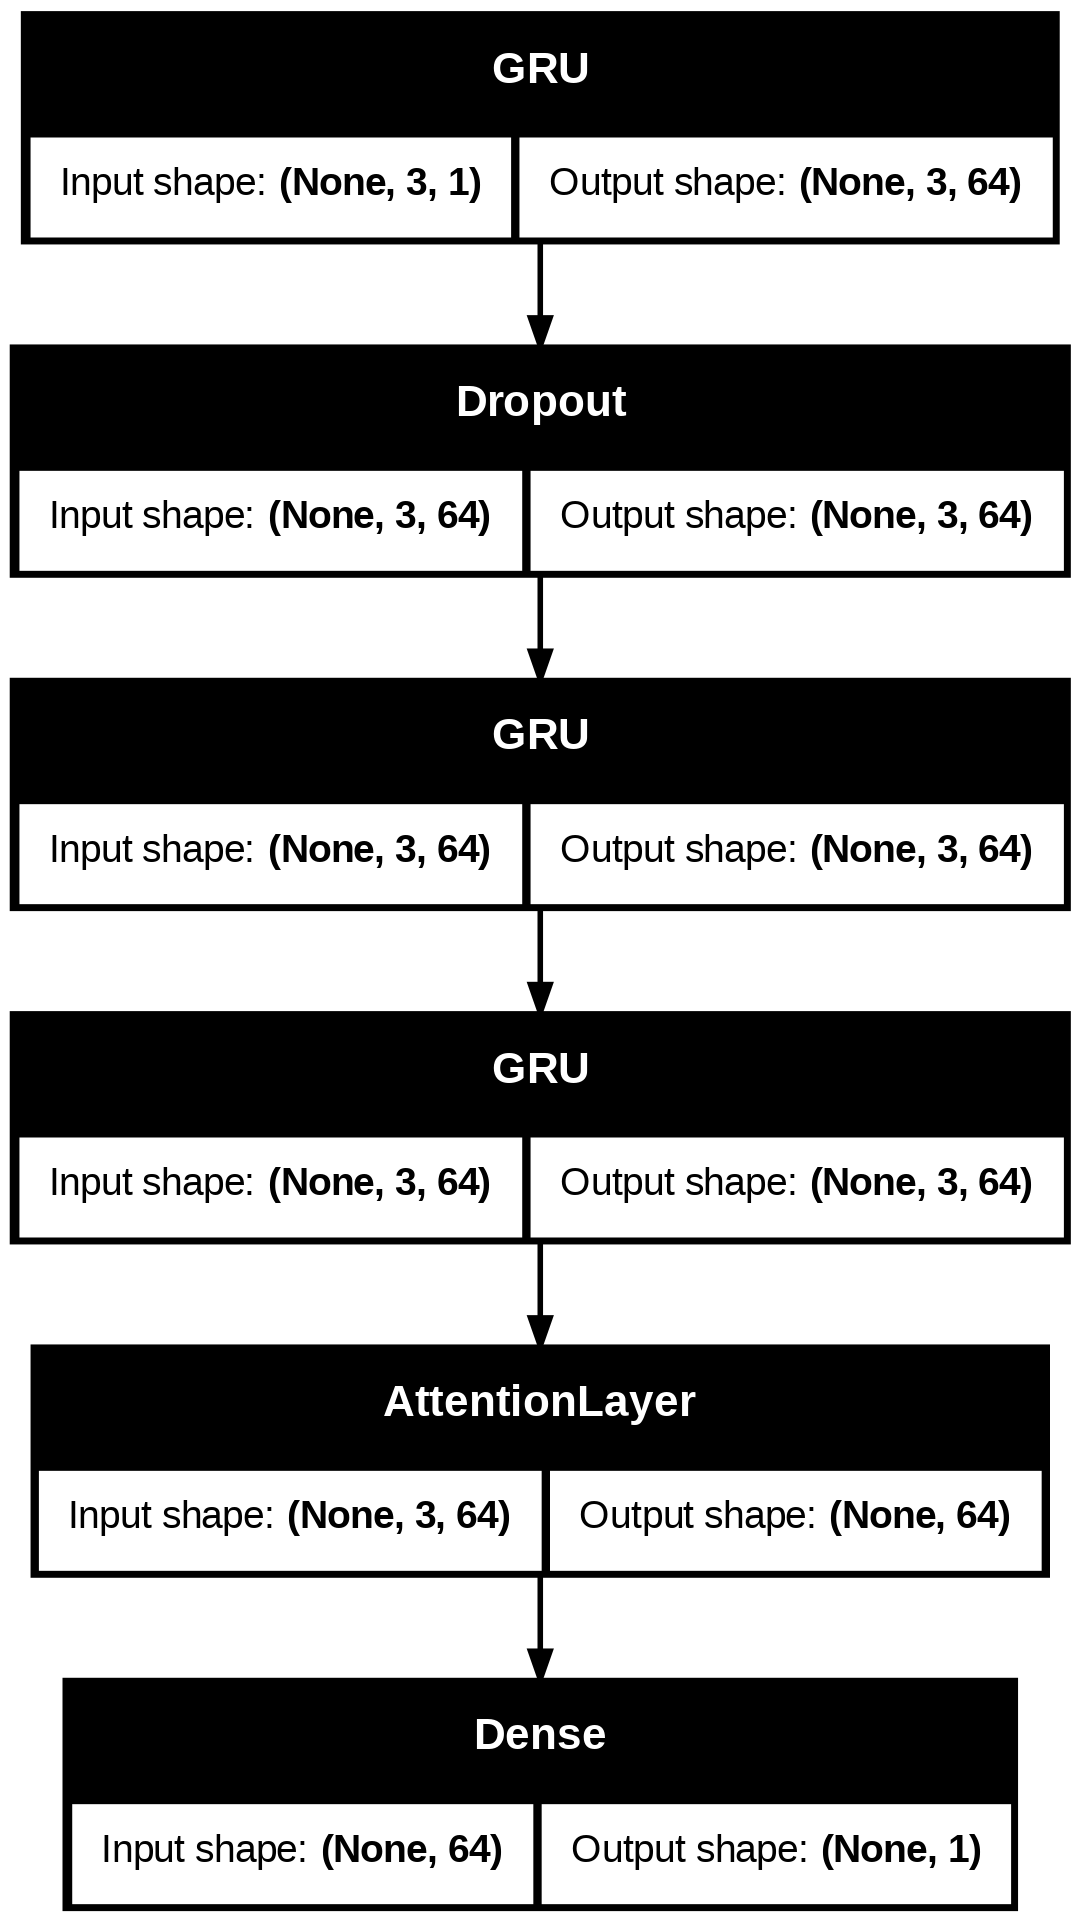

In [ ]:
# Summary dari model
att_best_model.summary()

plot_model(att_best_model,to_file='att_modelgru.png', show_shapes=True)

# att_best_model.save('att_modelgru.h5')

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.0644 - val_loss: 0.0960
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0336 - val_loss: 0.0790
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0251 - val_loss: 0.0551
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0172 - val_loss: 0.0179
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0132 - val_loss: 0.0246
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0117 - val_loss: 0.0146
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0097 - val_loss: 0.0132
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0086 - val_loss: 0.0124
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0073 - val_loss: 0.0118
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0063 - val_loss: 0.0110
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0061 - val_loss: 0.0122
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0053 - val_loss: 0.0089


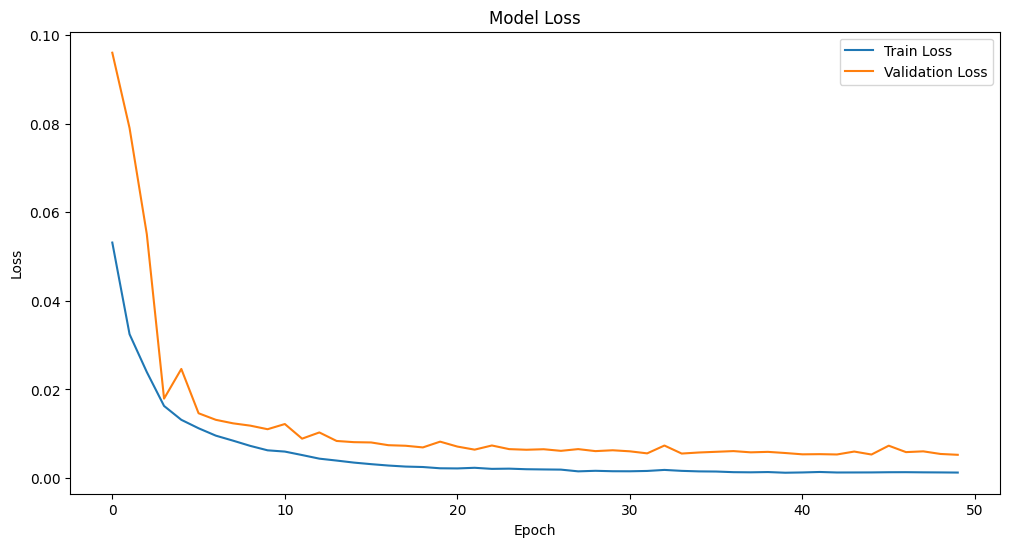

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
# Melatih model
history = att_best_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Prediksi pada test set & train set
test_predictions_attention_gru = att_best_model.predict(X_test)
train_predictions_attention_gru = att_best_model.predict(X_train)


In [ ]:
att_history_df = history.history
att_history_df = pd.DataFrame(att_history_df)
att_history_df.to_csv('att_history_df.csv', index=False)
att_history_df.to_excel('att_history_df.xlsx', index=False)

In [ ]:
att_history_df

,loss,val_loss
0,0.053165,0.096016
1,0.032479,0.079015
2,0.023936,0.055062
3,0.016282,0.017937
4,0.013153,0.024634
5,0.011246,0.014632
6,0.009579,0.013153
7,0.008446,0.012358
8,0.007264,0.011835
9,0.006267,0.011030


MAE: 1268.9269807235053
RMSE: 1720.6385211503234
MAPE: 7.805480513584994%
R2: 0.8288949261420305


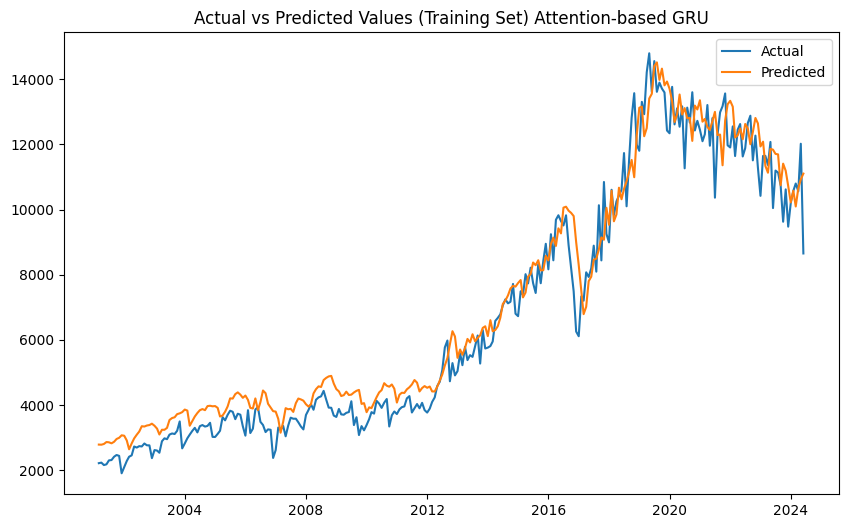

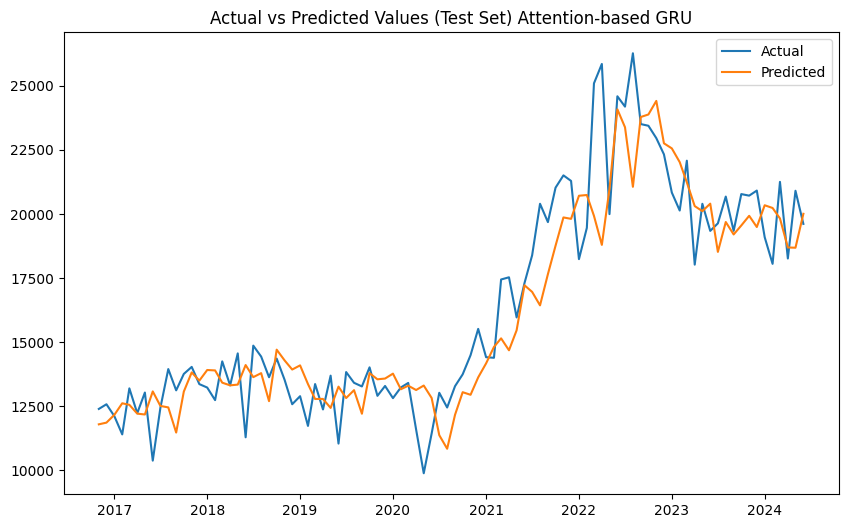

In [ ]:
# Inverse transform predictions ke skala asli
test_predictions_attention_gru_inv = scaler.inverse_transform(test_predictions_attention_gru)
train_predictions_attention_gru_inv = scaler.inverse_transform(train_predictions_attention_gru)

# Inverse transform actual Y_test values
att_Y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Inverse transform actual Y_test values
att_Y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))

# Compute MAE
att_mae = mean_absolute_error(att_Y_test_inv, test_predictions_attention_gru_inv)

# Compute RMSE
att_rmse = np.sqrt(mean_squared_error(att_Y_test_inv, test_predictions_attention_gru_inv))

# Compute MAPE
att_mape = mean_absolute_percentage_error(att_Y_test_inv, test_predictions_attention_gru_inv) * 100

# Compute R^2
att_r2 = r2_score(att_Y_test_inv, test_predictions_attention_gru_inv)

# Print hasil evaluasi
print(f'MAE: {att_mae}')
print(f'RMSE: {att_rmse}')
print(f'MAPE: {att_mape}%')
print(f'R2: {att_r2}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(train_predictions_attention_gru):], att_Y_train_inv, label='Actual')
plt.plot(data.index[-len(train_predictions_attention_gru):], train_predictions_attention_gru_inv, label='Predicted')
plt.title('Actual vs Predicted Values (Training Set) Attention-based GRU')
plt.legend()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(test_predictions_attention_gru):], att_Y_test_inv, label='Actual')
plt.plot(data.index[-len(test_predictions_attention_gru):], test_predictions_attention_gru_inv, label='Predicted')
plt.title('Actual vs Predicted Values (Test Set) Attention-based GRU')
plt.legend()
plt.show()

In [ ]:
# Extract the last sequence from the test data
last_sequence = data_scaled[-time_steps:]

# Reshape it to fit the model's expected input shape
last_sequence = last_sequence.reshape((1, time_steps, 1))

# Predict the next month
next_month_prediction_scaled = att_best_model.predict(last_sequence)

# Inverse transform the predicted value to get the actual value
next_month_prediction = scaler.inverse_transform(next_month_prediction_scaled)

# Print the predicted value for the next month
print(f'Predicted NonMigas value for the next month: {next_month_prediction[0][0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted NonMigas value for the next month: 18811.787109375


In [ ]:
att_train_predictions_inv_df = pd.DataFrame(train_predictions_attention_gru_inv, columns=['Prediksi'])
att_y_train_inv_df = pd.DataFrame(att_Y_train_inv, columns=['Aktual'])
att_train = pd.concat([att_train_predictions_inv_df, att_y_train_inv_df], axis=1)
att_train.to_csv('att_train.csv', index=False)
att_train.to_excel('att_train.xlsx', index=False)

In [ ]:
att_test_predictions_inv_df = pd.DataFrame(test_predictions_attention_gru_inv,columns=['Prediksi'])
att_y_test_inv_df = pd.DataFrame(att_Y_test_inv, columns=['Aktual'])
att_test = pd.concat([att_test_predictions_inv_df, att_y_test_inv_df], axis=1)
att_test.to_csv('att_test.csv', index=False)
att_test.to_excel('att_test.xlsx', index=False)

In [ ]:
att_Y_train_inv

array([[ 2213.5],
       [ 2229.7],
       [ 2155.3],
       [ 2178.4],
       [ 2299.7],
       [ 2308.8],
       [ 2411.3],
       [ 2464.2],
       [ 2437.3],
       [ 1903.2],
       [ 2093. ],
       [ 2280.5],
       [ 2410.8],
       [ 2453.3],
       [ 2725.2],
       [ 2692.1],
       [ 2735.7],
       [ 2726.6],
       [ 2817.3],
       [ 2762.3],
       [ 2759.7],
       [ 2367.3],
       [ 2614.4],
       [ 2600.9],
       [ 2533.3],
       [ 2886. ],
       [ 2975.7],
       [ 2949.8],
       [ 3090.4],
       [ 3125.2],
       [ 3108.7],
       [ 3206.8],
       [ 3495.2],
       [ 2667.9],
       [ 2817.1],
       [ 2977.3],
       [ 3090.4],
       [ 3204.5],
       [ 3298.3],
       [ 3157.9],
       [ 3349.3],
       [ 3383.2],
       [ 3336.9],
       [ 3357.1],
       [ 3452.8],
       [ 3020.2],
       [ 3017.8],
       [ 3113.2],
       [ 3207.3],
       [ 3625.8],
       [ 3527.9],
       [ 3698.2],
       [ 3823.2],
       [ 3790.5],
       [ 3564.4],
       [ 3

In [ ]:
train_predictions_attention_gru_inv

array([[ 2783.8489],
       [ 2780.6133],
       [ 2802.4333],
       [ 2862.1968],
       [ 2854.0068],
       [ 2822.4106],
       [ 2870.0654],
       [ 2955.6716],
       [ 2992.6653],
       [ 3068.982 ],
       [ 3056.4988],
       [ 2909.9504],
       [ 2640.5107],
       [ 2818.8533],
       [ 2974.064 ],
       [ 3086.398 ],
       [ 3183.5374],
       [ 3347.631 ],
       [ 3338.    ],
       [ 3369.2954],
       [ 3383.9966],
       [ 3425.7039],
       [ 3362.517 ],
       [ 3273.3462],
       [ 3093.5334],
       [ 3239.4385],
       [ 3238.1648],
       [ 3296.9934],
       [ 3539.4673],
       [ 3598.6096],
       [ 3622.6328],
       [ 3718.5566],
       [ 3742.888 ],
       [ 3779.5537],
       [ 3858.8013],
       [ 3827.745 ],
       [ 3362.6982],
       [ 3506.9526],
       [ 3645.486 ],
       [ 3753.4036],
       [ 3839.704 ],
       [ 3874.3318],
       [ 3840.4326],
       [ 3965.6497],
       [ 3975.844 ],
       [ 3959.2212],
       [ 3966.4785],
       [ 3910

In [ ]:
att_Y_test_inv

array([[12399.9],
       [12582.2],
       [12119.1],
       [11407.3],
       [13202.2],
       [12233.5],
       [13039.5],
       [10385.1],
       [12446.1],
       [13954.4],
       [13125.2],
       [13764.4],
       [14039. ],
       [13368.1],
       [13233.6],
       [12743.6],
       [14254.5],
       [13317.4],
       [14565.2],
       [11295. ],
       [14868.2],
       [14441.4],
       [13636.1],
       [14363.8],
       [13538.8],
       [12583.3],
       [12896.8],
       [11737.8],
       [13370.4],
       [12380. ],
       [13697.6],
       [11049.2],
       [13837.9],
       [13419.1],
       [13277.1],
       [14021.5],
       [12910.8],
       [13295.5],
       [12821.1],
       [13236.9],
       [13413.9],
       [11597.7],
       [ 9891.7],
       [11439.4],
       [13029.5],
       [12455.7],
       [13288.9],
       [13748.9],
       [14496.2],
       [15520.8],
       [14416.4],
       [14394.8],
       [17446.9],
       [17532.4],
       [15967.4],
       [17

In [ ]:
test_predictions_attention_gru_inv

array([[11799.977 ],
       [11866.648 ],
       [12169.515 ],
       [12620.261 ],
       [12561.2   ],
       [12216.901 ],
       [12183.359 ],
       [13083.047 ],
       [12517.393 ],
       [12459.871 ],
       [11479.391 ],
       [13076.167 ],
       [13823.59  ],
       [13503.892 ],
       [13917.947 ],
       [13901.493 ],
       [13424.166 ],
       [13319.271 ],
       [13348.974 ],
       [14111.268 ],
       [13639.373 ],
       [13795.969 ],
       [12703.07  ],
       [14711.147 ],
       [14293.6045],
       [13936.006 ],
       [14098.443 ],
       [13369.538 ],
       [12787.906 ],
       [12790.316 ],
       [12439.611 ],
       [13269.423 ],
       [12824.859 ],
       [13131.944 ],
       [12212.979 ],
       [13795.387 ],
       [13554.97  ],
       [13585.238 ],
       [13776.316 ],
       [13166.881 ],
       [13306.708 ],
       [13137.997 ],
       [13311.76  ],
       [12827.716 ],
       [11377.214 ],
       [10847.754 ],
       [12173.3125],
       [13052

# GRU-STL

In [ ]:
# Load and preprocess the data
data = pd.read_csv('/content/Keseluruhan NonMigas.csv', parse_dates=['date'], index_col='date')

# Split data into training and testing sets (75% train, 25% test)
train_size = int(len(data) * 0.75)
train_data, test_data = data[:train_size], data[train_size:]

# STL decomposition on training set
stl = STL(train_data['NonMigas'], seasonal=13)
result = stl.fit()

# Extract trend, seasonal, and residual components from training data
trend_train = result.trend
seasonal_train = result.seasonal
residual_train = result.resid

# Normalize residuals for GRU model
scaler = MinMaxScaler()
residual_train_scaled = scaler.fit_transform(residual_train.values.reshape(-1, 1))

X_train, y_train = create_sequences(residual_train_scaled, time_steps)

<ipython-input-12-2a8b0bd805c6>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('/content/Keseluruhan NonMigas.csv', parse_dates=['date'], index_col='date')


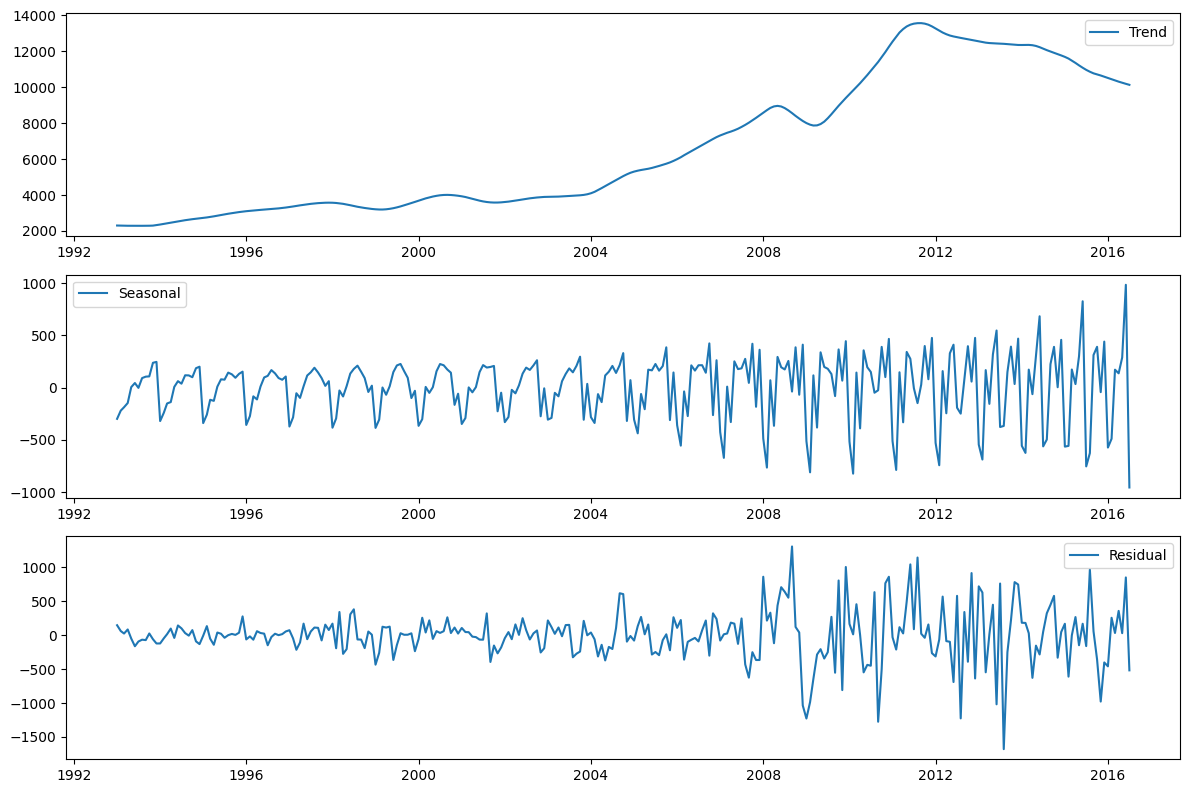

In [ ]:
# Visualize components train
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(result.trend, label='Trend')
plt.legend()
plt.subplot(312)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()
plt.subplot(313)
plt.plot(result.resid, label='Residual')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
result.trend

,trend
date,
1993-01-01,2292.766049
1993-02-01,2287.006657
1993-03-01,2282.554461
1993-04-01,2279.392775
1993-05-01,2277.447217
...,...
2016-03-01,10371.348175
2016-04-01,10305.834216
2016-05-01,10243.655674


In [ ]:
result.seasonal

,season
date,
1993-01-01,-300.018858
1993-02-01,-221.451498
1993-03-01,-188.707668
1993-04-01,-148.263044
1993-05-01,3.964050
...,...
2016-03-01,171.139523
2016-04-01,136.223916
2016-05-01,287.923352


In [ ]:
result.resid

,resid
date,
1993-01-01,144.852809
1993-02-01,59.444841
1993-03-01,22.453207
1993-04-01,82.370269
1993-05-01,-51.711267
...,...
2016-03-01,30.312302
2016-04-01,355.941868
2016-05-01,27.920975


In [ ]:
# Build STL = GRU model
def build_stl_GRU(units=64, dropout=0.2, learning_rate=0.001):
    model = models.Sequential()
    model.add(GRU(units, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(time_steps, 1)))
    model.add(Dropout(dropout))
    model.add(GRU(units))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap the model for GridSearch
model = KerasRegressor(
    build_fn=build_stl_GRU,
    epochs=50,
    batch_size=32,
    verbose=0
)

# Define the grid of hyperparameters to search
param_grid = { # Changed param_grid keys
    'model__units': [32, 64, 128],
    'model__dropout': [0.1, 0.2, 0.3],
    'model__learning_rate': [0.001, 0.01, 0.1]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3)

# Fit GridSearchCV
grid_result = grid_search.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Build the best model from the grid search results
stl_best_model = build_stl_GRU(units=grid_result.best_params_['model__units'],
                                      dropout=grid_result.best_params_['model__dropout'],
                                      learning_rate=grid_result.best_params_['model__learning_rate'])

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in 

Best: -0.085169 using {'model__dropout': 0.3, 'model__learning_rate': 0.001, 'model__units': 128}


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_35 (GRU)                         │ (None, 3, 128)              │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_36 (GRU)                         │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149,505 (584.00 KB)

 Trainable params: 149,505 (584.00 KB)

 Non-trainable params: 0 (0.00 B)

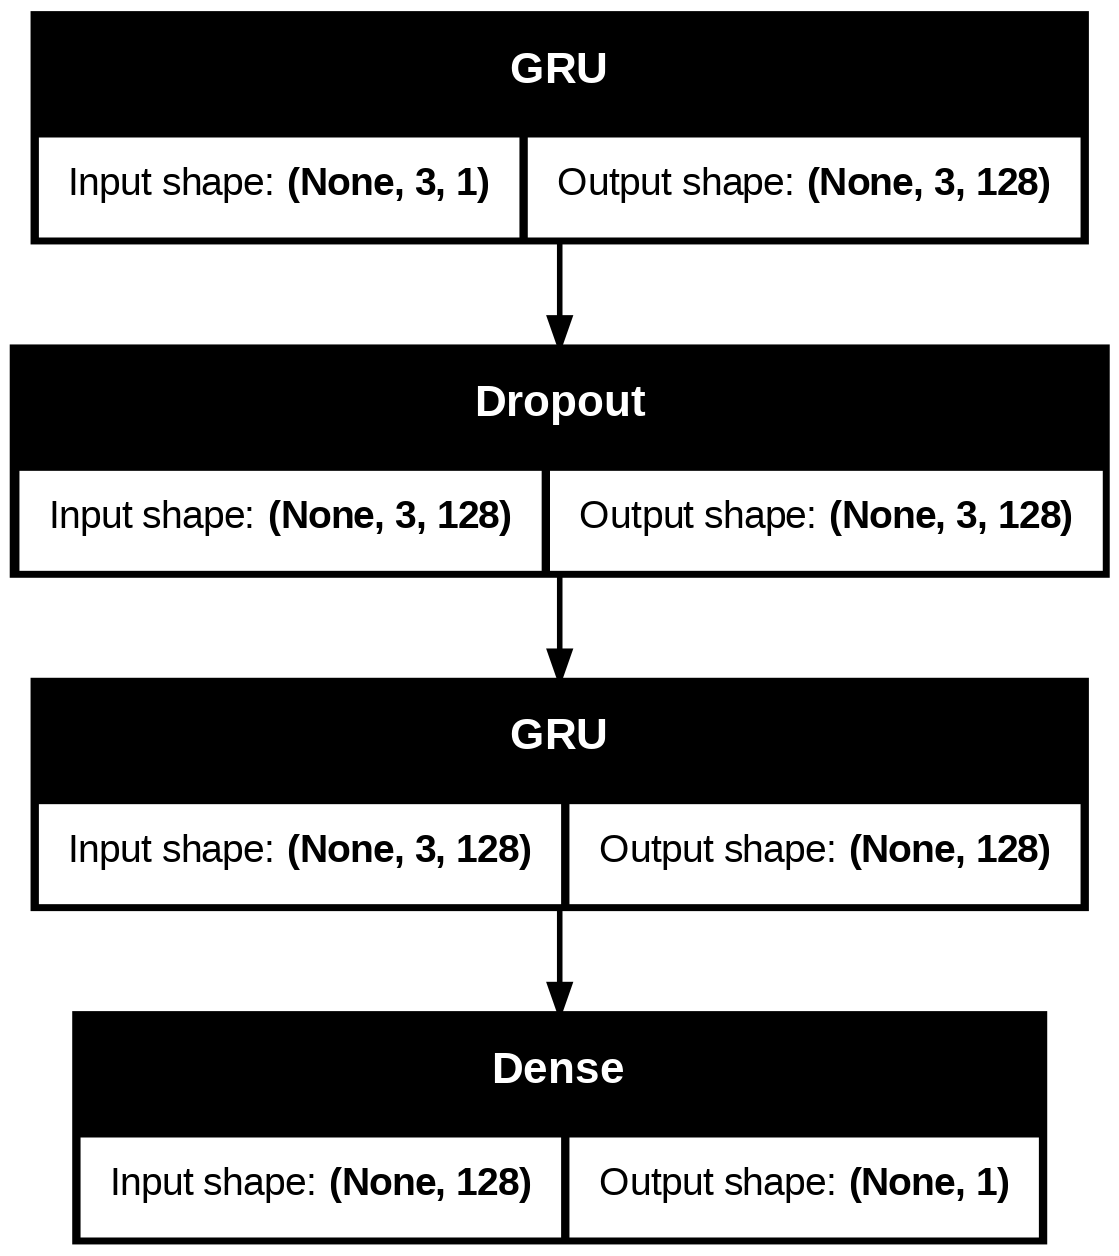

In [ ]:
stl_best_model.summary()

plot_model(stl_best_model,to_file='stl_modelgru.png', show_shapes=True)

# stk_best_model.save('stl_modelgru.h5')

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.2334 - val_loss: 0.0663
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0527 - val_loss: 0.0613
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0294 - val_loss: 0.0655
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0364 - val_loss: 0.0536
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0258 - val_loss: 0.0551
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0263 - val_loss: 0.0506
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0218 - val_loss: 0.0498
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0233 - val_loss: 0.0490
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0203 - val_loss: 0.0476
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0183 - val_loss: 0.0467
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0205 - val_loss: 0.0461
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0206 - val_loss: 0.0459
E

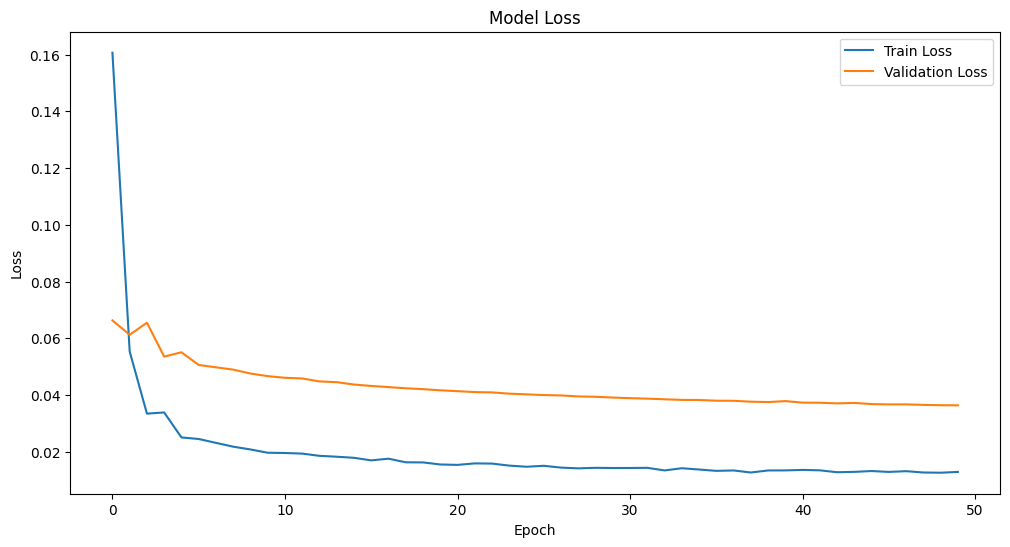

In [ ]:
# Train the GRU model
history = stl_best_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
stl_history_df = history.history
stl_history_df = pd.DataFrame(stl_history_df)
stl_history_df.to_csv('stl_history_df.csv', index=False)
stl_history_df.to_excel('stl_history_df.xlsx', index=False)

In [ ]:
stl_history_df

,loss,val_loss
0,0.160659,0.066333
1,0.055365,0.061258
2,0.033482,0.065513
3,0.033888,0.053571
4,0.025086,0.055099
5,0.024537,0.050634
6,0.023176,0.049793
7,0.021829,0.048986
8,0.020854,0.047604
9,0.019692,0.046692


In [ ]:
# ----- Test Set Evaluation -----

# Perform STL decomposition on test set
stl_test = STL(test_data['NonMigas'], seasonal=13)
result_test = stl_test.fit()

# Extract components from the test set
trend_test = result_test.trend
seasonal_test = result_test.seasonal
residual_test = result_test.resid

# Normalize test residuals
residual_test_scaled = scaler.transform(residual_test.values.reshape(-1, 1))

# Prepare test data for GRU prediction
X_test, Y_test = create_sequences(residual_test_scaled, time_steps)

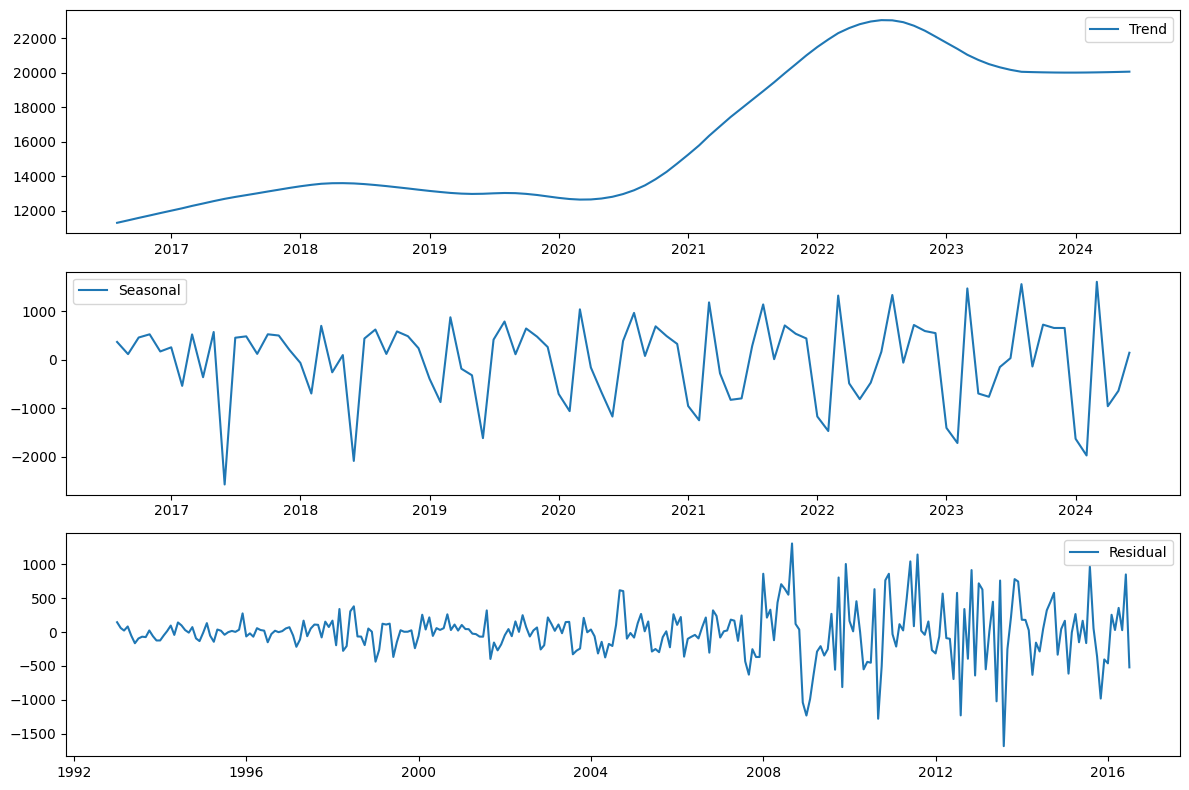

In [ ]:
# Visualize components test
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(result_test.trend, label='Trend')
plt.legend()
plt.subplot(312)
plt.plot(result_test.seasonal, label='Seasonal')
plt.legend()
plt.subplot(313)
plt.plot(result.resid, label='Residual')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
result_test.trend

,trend
date,
2016-08-01,11308.242651
2016-09-01,11450.845813
2016-10-01,11592.164843
2016-11-01,11732.293627
2016-12-01,11871.615608
...,...
2024-02-01,20005.162685
2024-03-01,20013.761534
2024-04-01,20024.982167


In [ ]:
result_test.seasonal

,season
date,
2016-08-01,370.896674
2016-09-01,119.318060
2016-10-01,462.242184
2016-11-01,528.460888
2016-12-01,174.466500
...,...
2024-02-01,-1972.045692
2024-03-01,1612.223965
2024-04-01,-955.477161


In [ ]:
result_test.resid

,resid
date,
2016-08-01,-116.039325
2016-09-01,-51.863873
2016-10-01,-366.507026
2016-11-01,139.145485
2016-12-01,536.117892
...,...
2024-02-01,22.883007
2024-03-01,-373.585499
2024-04-01,-804.605007


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAE: 589.8313370650935
RMSE: 868.9326573203907
MAPE: 3.568275950992267%
R2: 0.9563629036581007


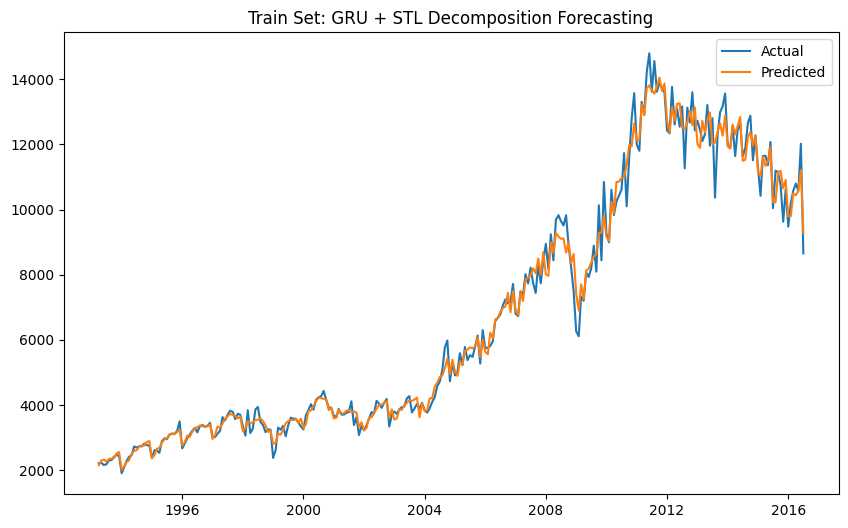

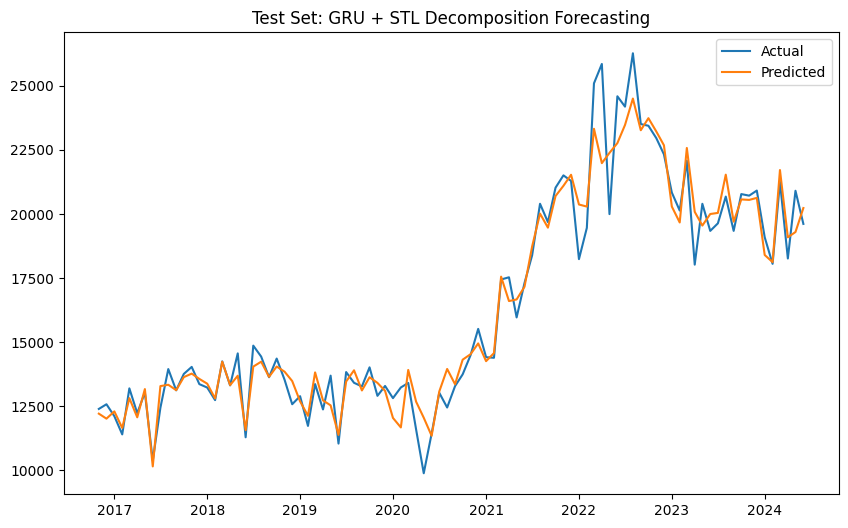

In [ ]:
# Make predictions with GRU on the test set & train set
stl_predictions_test = stl_best_model.predict(X_test)
stl_predictions_train = stl_best_model.predict(X_train)

# Inverse transform the predictions to get the original scale
stl_predictions_test = scaler.inverse_transform(stl_predictions_test).flatten() # Flatten the array
stl_predictions_train = scaler.inverse_transform(stl_predictions_train).flatten() # Flatten the array

# Combine GRU predictions with trend and seasonal components from the test set
final_predictions_test = trend_test[-len(stl_predictions_test):] + seasonal_test[-len(stl_predictions_test):] + stl_predictions_test

# Combine GRU predictions with trend and seasonal components from the train set
final_predictions_train = trend_train[-len(stl_predictions_train):] + seasonal_train[-len(stl_predictions_train):] + stl_predictions_train


stl_y_train_inv = train_data['NonMigas'][-len(final_predictions_train):]
stl_y_test_inv = test_data['NonMigas'][-len(final_predictions_test):]

# Compute MAE
stl_mae = mean_absolute_error(stl_y_test_inv, final_predictions_test)

# Compute RMSE
stl_rmse = np.sqrt(mean_squared_error(stl_y_test_inv, final_predictions_test))

# Compute MAPE
stl_mape = mean_absolute_percentage_error(stl_y_test_inv, final_predictions_test) * 100

# Compute R^2
stl_r2 = r2_score(stl_y_test_inv, final_predictions_test)

# Print evaluation metrics
print(f'MAE: {stl_mae}')
print(f'RMSE: {stl_rmse}')
print(f'MAPE: {stl_mape}%')
print(f'R2: {stl_r2}')

# ... (rest of the code remains the same)
# Plot the results on train data
plt.figure(figsize=(10, 6))
plt.plot(train_data.index[-len(final_predictions_train):], stl_y_train_inv, label='Actual')
plt.plot(train_data.index[-len(final_predictions_train):], final_predictions_train, label='Predicted')
plt.title('Train Set: GRU + STL Decomposition Forecasting')
plt.legend()
plt.show()

# Plot the results on test data
plt.figure(figsize=(10, 6))
plt.plot(test_data.index[-len(final_predictions_test):], stl_y_test_inv, label='Actual')
plt.plot(test_data.index[-len(final_predictions_test):], final_predictions_test, label='Predicted')
plt.title('Test Set: GRU + STL Decomposition Forecasting')
plt.legend()
plt.show()

In [ ]:
def predict_next_month(data, stl_model, scaler, time_step=3):
    # STL decomposition on the entire dataset to get the latest trend and seasonal components
    stl_last = STL(data['NonMigas'], seasonal=13)
    result_last = stl_last.fit()

    # Extract the last trend and seasonal components
    last_trend = result_last.trend[-1]
    last_seasonal = result_last.seasonal[-1]

    # Get the last residuals from the data for prediction
    residuals = result_last.resid
    residuals_scaled = scaler.transform(residuals.values.reshape(-1, 1))
    last_residuals = residuals_scaled[-time_step:]

    # Reshape for GRU input
    X_next = last_residuals.reshape(1, time_step, 1)

    # Predict the residual for the next month
    predicted_residual_next = stl_best_model.predict(X_next)
    predicted_residual_next = scaler.inverse_transform(predicted_residual_next).flatten()[0]

    # Combine the predicted residual with the last known trend and seasonal components
    predicted_value_next = last_trend + last_seasonal + predicted_residual_next

    # Prepare the next month's date
    last_date = data.index[-1]
    next_date = pd.date_range(start=last_date, periods=2, freq='M')[1]  # Get the next month

    # Create a DataFrame with the predicted value
    predicted_data = pd.DataFrame({'NonMigas': [predicted_value_next]}, index=[next_date])

    # Combine with the original data for visualization
    combined_data = pd.concat([data, predicted_data])

    return predicted_value_next, combined_data

# Example usage
predicted_value, updated_data = predict_next_month(data, stl_best_model, scaler, time_step=3)

# Print the predicted value for the next month
print(f'Predicted value for the next month: {predicted_value}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted value for the next month: 19894.51531291092


<ipython-input-29-e0d48beb05f6>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_trend = result_last.trend[-1]
<ipython-input-29-e0d48beb05f6>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_seasonal = result_last.seasonal[-1]
<ipython-input-29-e0d48beb05f6>:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  next_date = pd.date_range(start=last_date, periods=2, freq='M')[1]  # Get the next month


In [ ]:
stl_train_predictions_inv_df = pd.DataFrame(final_predictions_train, columns=['Prediksi'])
stl_y_train_inv_df = pd.DataFrame(stl_y_train_inv, columns=['Aktual'])
stl_train = pd.concat([stl_train_predictions_inv_df, stl_y_train_inv_df], axis=1)
stl_train.to_csv('stl_train.csv', index=False)
stl_train.to_excel('stl_train.xlsx', index=False)

In [ ]:
stl_test_predictions_inv_df = pd.DataFrame(final_predictions_test,columns=['Prediksi'])
stl_y_test_inv_df = pd.DataFrame(stl_y_test_inv, columns=['Aktual'])
stl_test = pd.concat([stl_test_predictions_inv_df, stl_y_test_inv_df], axis=1)
stl_test.to_csv('stl_test.csv', index=False)
stl_test.to_excel('stl_test.xlsx', index=False)

In [ ]:
stl_y_train_inv.values

In [ ]:
final_predictions_train.values

In [ ]:
stl_y_test_inv.values

In [ ]:
final_predictions_test.values

# Comparison

In [ ]:
comp = {'Model': ['stk_gru', 'bid_gru', 'att_gru', 'stl_gru'],
        'MAE': [stk_mae, bid_mae, att_mae, stl_mae],
        'RMSE': [stk_rmse, bid_rmse, att_rmse, stl_rmse],
        'MAPE': [stk_mape, bid_mape, att_mape, stl_mape],
        'R^2' : [stk_r2, bid_r2, att_r2, stl_r2]
        }


df_comp = pd.DataFrame(comp)
print(df_comp)

     Model        MAE       RMSE  MAPE     R^2
0  stk_gru  1237.3667  1646.3960  7.60  0.8433
1  bid_gru  1197.5976  1614.4568  7.46  0.8493
2  att_gru  1268.9269  1720.6385  7.80  0.8288
3  stl_gru   589.8313   868.9326  3.56  0.9563


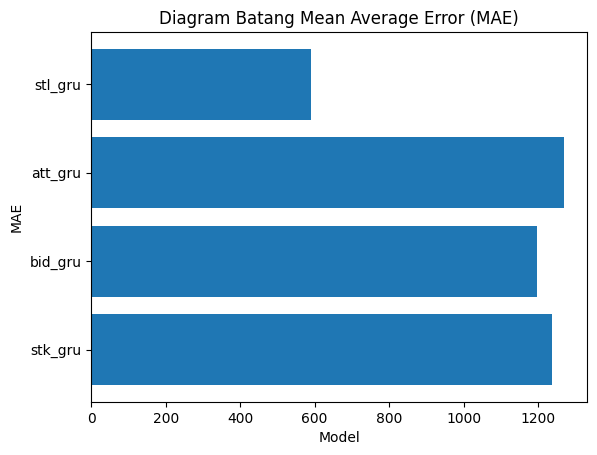

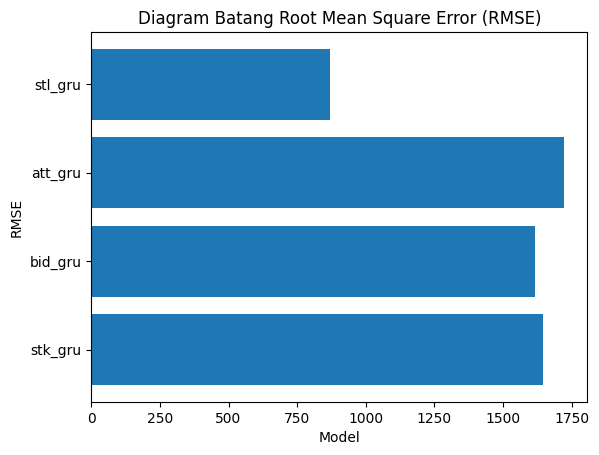

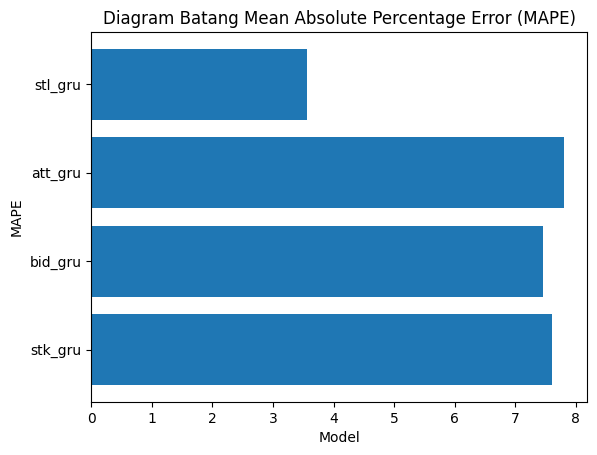

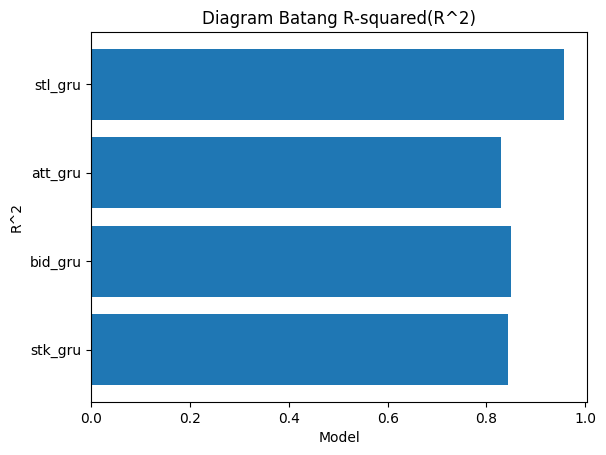

In [ ]:
#Compared MAE
plt.barh(df_comp['Model'], df_comp['MAE'])
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Diagram Batang Mean Average Error (MAE)')

# Tampilkan diagram
plt.show()

#Compared RMSE
plt.barh(df_comp['Model'], df_comp['RMSE'])
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Diagram Batang Root Mean Square Error (RMSE)')

# Tampilkan diagram
plt.show()

#Compared MAPE
plt.barh(df_comp['Model'], df_comp['MAPE'])
plt.xlabel('Model')
plt.ylabel('MAPE')
plt.title('Diagram Batang Mean Absolute Percentage Error (MAPE)')

# Tampilkan diagram
plt.show()

#Compared R2
plt.barh(df_comp['Model'], df_comp['R^2'])
plt.xlabel('Model')
plt.ylabel('R^2')
plt.title('Diagram Batang R-squared(R^2)')

# Tampilkan diagram
plt.show()